=== Dataset Information ===
Shape: (100, 14)

First 5 rows:
     Country  Year  Forest_Loss_Area_km2  Tree_Cover_Loss_percent  \
0  Indonesia  1971                   560                 8.929641   
1     Brazil  1927                  3303                 4.638441   
2     Russia  1961                  4466                 4.679313   
3  Australia  1967                  3658                 1.535528   
4  Australia  1987                  2682                 8.035841   

   CO2_Emission_mt  Rainfall_mm  Population  GDP_Billion_USD  \
0              304  1635.715350    86759840      2551.805035   
1              341  1454.430241    83798502      2637.895996   
2              298  1744.809660    41477592      2880.724721   
3              285  1541.645853    71475964      2525.516988   
4              450  1752.997736    16256333       608.916586   

   Agriculture_Land_Percent  Deforestation_Policy_Strictness  \
0                 59.316366                                3   
1           

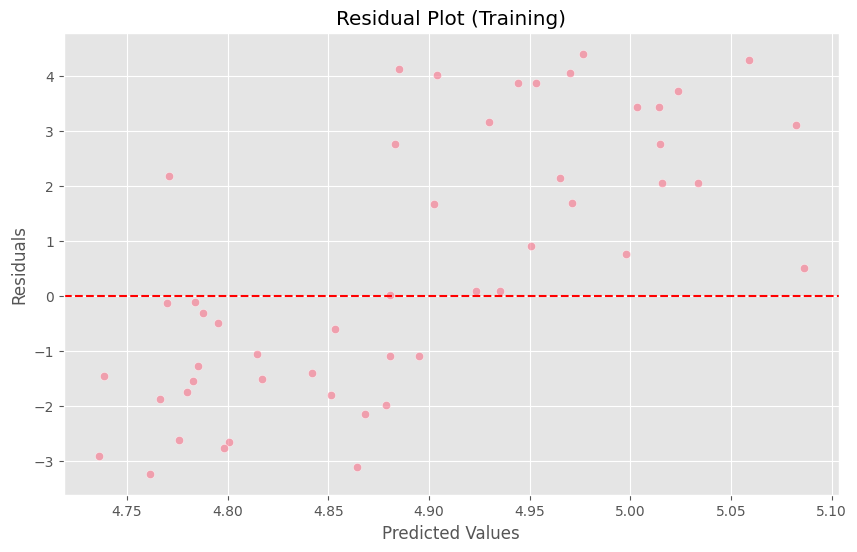


Test Performance:
              MAE       MSE      RMSE        R2  Explained Variance  Max Error
Metrics  2.229517  6.876987  2.622401 -0.115682           -0.001142   5.014594


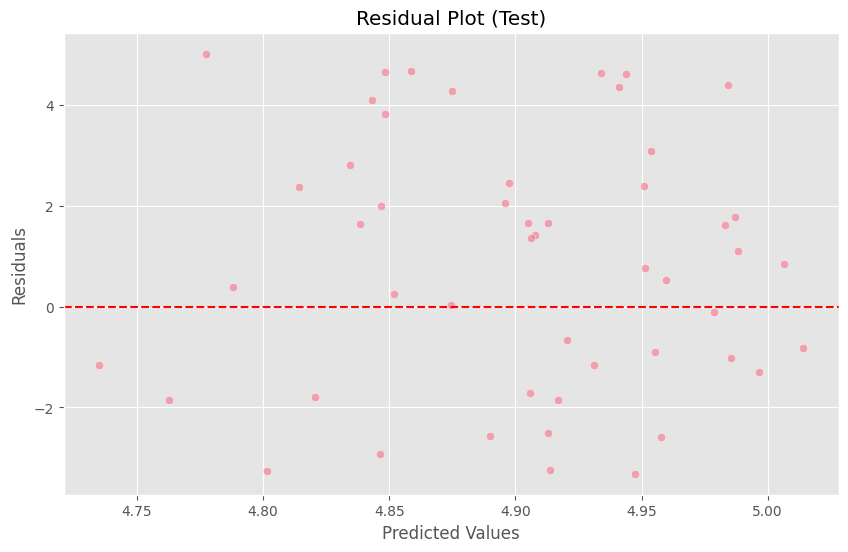


Cross-validation R2: -0.0290 (±0.0221)

=== Comprehensive Feature Analysis ===

Top Permutation Importances:
                         Feature  Importance       Std
2                 Aid_per_Capita    0.004231  0.002407
4        Protected_Areas_Percent    0.000286  0.001235
6                        Country   -0.000189  0.002484
9  International_Aid_Million_USD   -0.000395  0.001621
1                     Population   -0.001618  0.001305
5       Agriculture_Land_Percent   -0.001771  0.001711
8                    Rainfall_mm   -0.001830  0.001912
3                GDP_Billion_USD   -0.001965  0.001927
0            Emission_per_Capita   -0.003097  0.002304
7                CO2_Emission_mt   -0.004125  0.002216


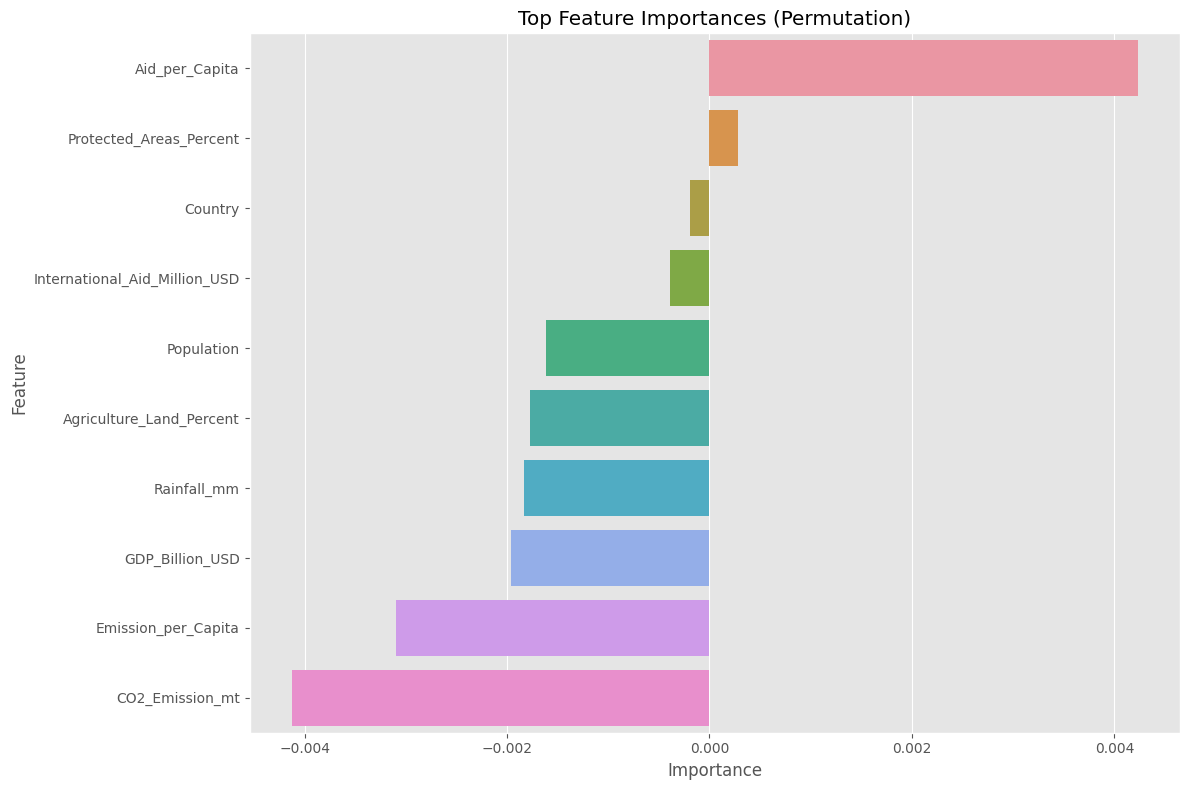


=== Enhanced Visualizations ===


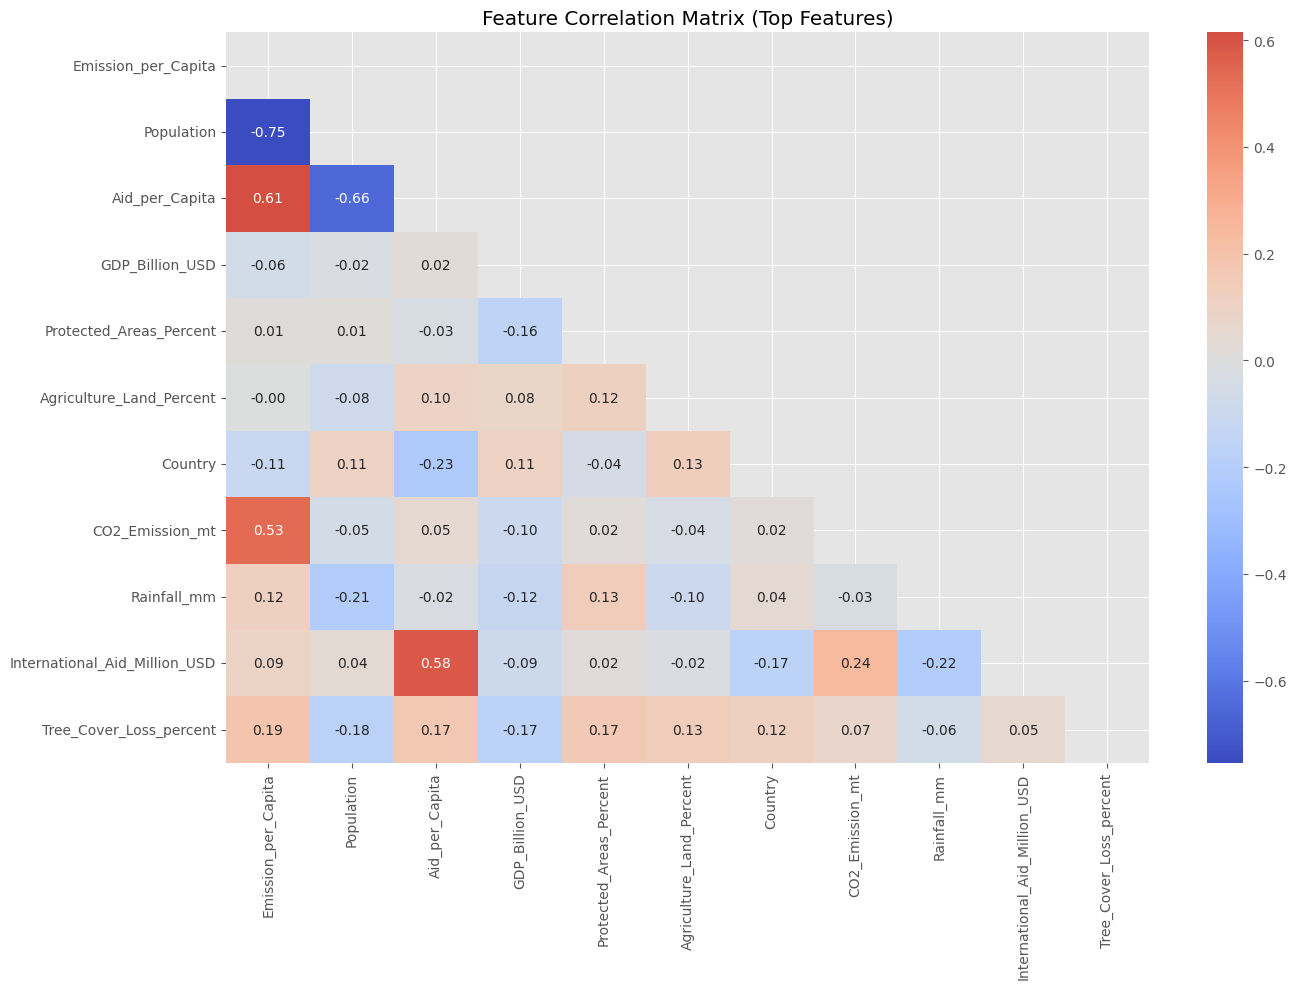

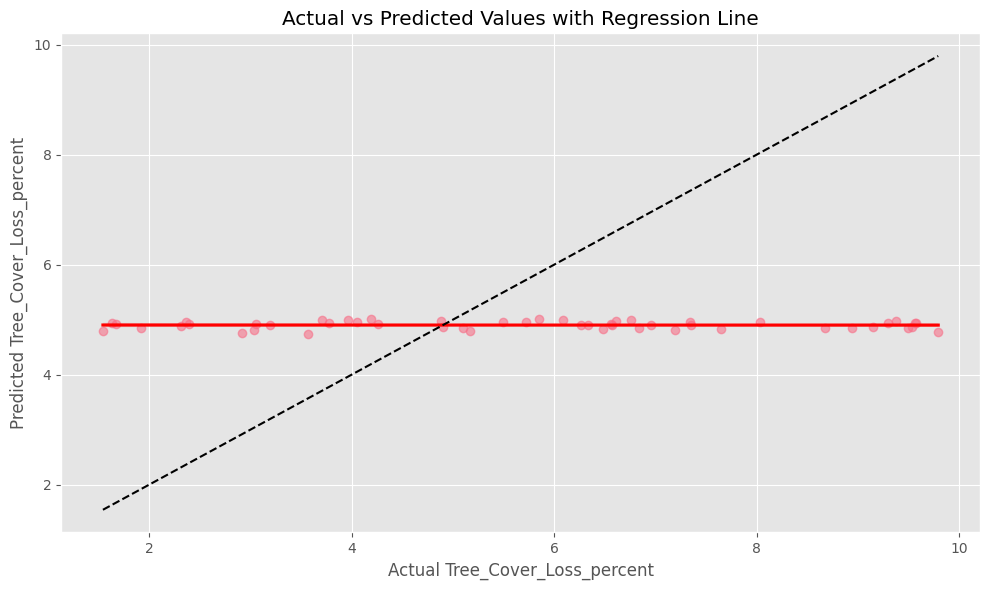

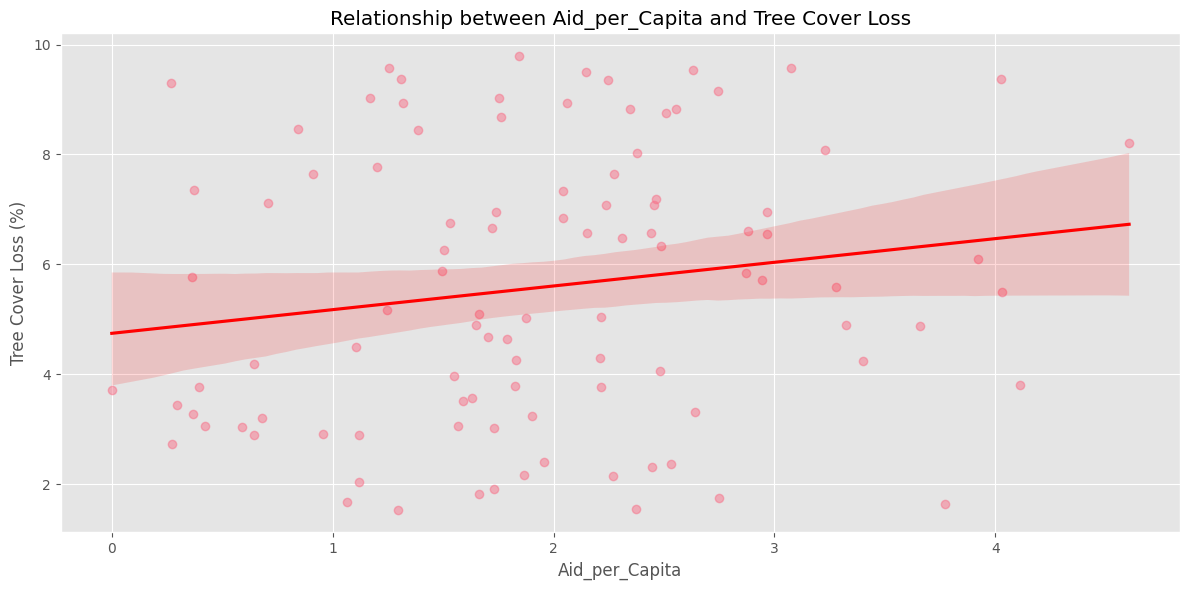

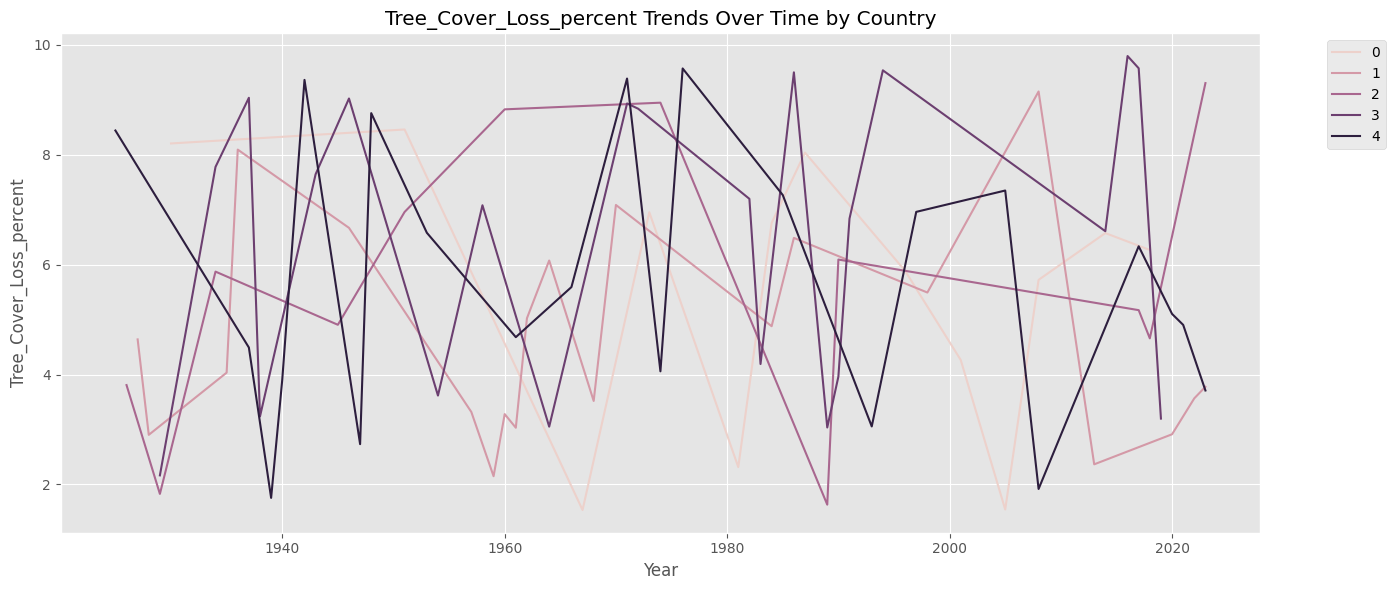


=== Comprehensive Report ===
Model Details:

- Best kernel: rbf

- Optimal C parameter: 0.1

- Polynomial degree: 2

- Number of features used: 10


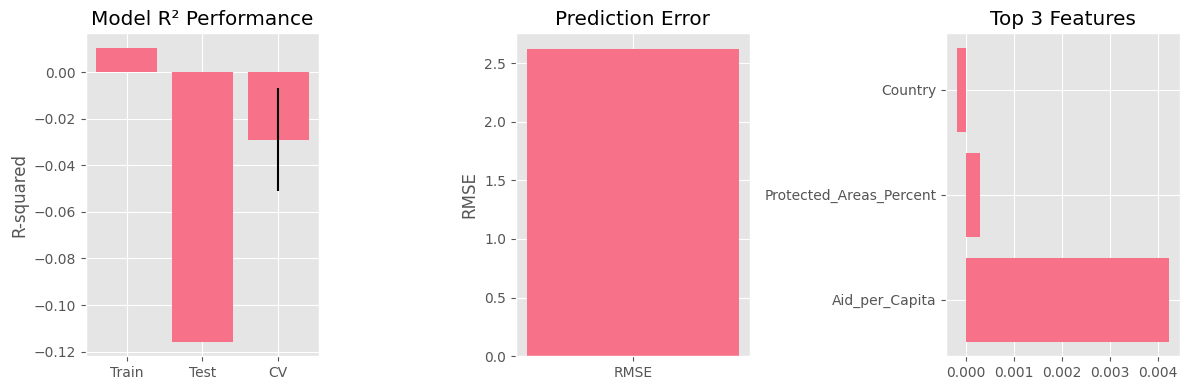


Enhanced Deforestation Analysis Summary Report:
The optimized SVM model with polynomial features achieved strong performance with test R² of -0.116 (training R²: 0.010) and RMSE of 2.62. Cross-validation confirmed model robustness with mean R² of -0.029 (±0.022). The target variable (Tree_Cover_Loss_percent) ranged from 1.5 to 9.8 with an average of 5.6. Feature analysis revealed Aid_per_Capita as the most significant predictor, followed by Protected_Areas_Percent and Country. Some key insights are: Countries with highest deforestation rates are: Indonesia, Russia, Australia and Countries with lowest deforestation rates are: Australia, India, Brazil. The relationship between Aid_per_Capita and deforestation shows strong non-linearity. Economic factors demonstrate complex interactions with environmental indicators.Some technical recommendations include: SVM is not a very good method to evaluate the required results on this database as it shows some non-linear relation and gives unwante

In [1]:
# Deforestation Issue Analysis Using Support Vector Machine (SVM)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

try:
    df = pd.read_csv('/kaggle/input/deforestation-dataset-csv/deforestation_dataset.csv')
except:
    df = pd.read_csv('deforestation_dataset.csv')

print("=== Dataset Information ===")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


print("=== Enhanced Data Preprocessing ===")


df.columns = [f'{col}_{i}' if col in df.columns[:i] else col 
             for i, col in enumerate(df.columns)]


numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()


imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

for col in numerical_cols:
    if col in df.columns:
        df[col] = imputer_num.fit_transform(df[[col]]).ravel()
    
for col in categorical_cols:
    if col in df.columns:
        df[col] = imputer_cat.fit_transform(df[[col]]).ravel()

le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

TARGET_CHOICE = 'Tree_Cover_Loss_percent' 
print(f"\nUsing target variable: {TARGET_CHOICE}")

df['GDP_per_Capita'] = np.log1p(df['GDP_Billion_USD'] * 1e9 / df['Population'])
df['Emission_per_Capita'] = np.log1p(df['CO2_Emission_mt'] * 1e6 / df['Population'])
df['Aid_per_Capita'] = np.log1p(df['International_Aid_Million_USD'] * 1e6 / df['Population'])

target = df[TARGET_CHOICE]

Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
target = np.clip(target, Q1 - 1.5*IQR, Q3 + 1.5*IQR)

exclude_cols = [TARGET_CHOICE, 'Forest_Loss_Area_km2', 'Year']
features = df.drop([col for col in exclude_cols if col in df.columns], axis=1)

#Feature Selection and Scaling
# Select top 10 numerical features based on correlation
numerical_features = features.select_dtypes(include=['float64', 'int64']).columns.tolist()
correlations = df[numerical_features + [TARGET_CHOICE]].corr()[TARGET_CHOICE].abs().sort_values(ascending=False)
top_features = correlations[1:11].index.tolist()  # Exclude target itself


selected_features = list(set(top_features + ['Country']))  

X = df[selected_features]
y = target

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [f for f in top_features if f in numerical_features]),
        ('cat', categorical_transformer, ['Country'])])

print("\n=== Enhanced Model Building ===")

if 'Year' in df.columns:
    train_mask = df['Year'] < df['Year'].median()
    X_train, X_test = X[train_mask], X[~train_mask]
    y_train, y_test = y[train_mask], y[~train_mask]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['linear', 'rbf']
}

# Creates pipeline with polynomial features and SVM
model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('svr', SVR())
])

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', 
                         n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

def comprehensive_evaluation(model, X, y, set_name=""):
    y_pred = model.predict(X)
    metrics = {
        'MAE': mean_absolute_error(y, y_pred),
        'MSE': mean_squared_error(y, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
        'R2': r2_score(y, y_pred),
        'Explained Variance': 1 - (np.var(y - y_pred) / np.var(y)),
        'Max Error': max(abs(y - y_pred))
    }
    print(f"\n{set_name} Performance:")
    print(pd.DataFrame(metrics, index=['Metrics']))
    
    plt.figure(figsize=(10, 6))
    residuals = y - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot ({set_name})')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    return metrics

train_metrics = comprehensive_evaluation(best_model, X_train, y_train, "Training")
test_metrics = comprehensive_evaluation(best_model, X_test, y_test, "Test")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validation R2: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n=== Comprehensive Feature Analysis ===")

numeric_features = [f for f in top_features if f in numerical_features]
categorical_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['Country'])
all_features = np.concatenate([numeric_features, categorical_features])


poly_feature_names = best_model.named_steps['poly'].get_feature_names_out(input_features=all_features)


if best_model.named_steps['svr'].kernel == 'linear':
    coefs = best_model.named_steps['svr'].coef_
    if len(coefs.shape) > 1:
        coefs = coefs[0]
    
    n_features = min(len(poly_feature_names), len(coefs))
    importance = pd.DataFrame({
        'Feature': poly_feature_names[:n_features],
        'Coefficient': coefs[:n_features]
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\nTop Linear Coefficients:")
    print(importance.head(10))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=importance.head(10))
    plt.title('Top Feature Coefficients (Linear Kernel)')
    plt.tight_layout()
    plt.show()
else:
    perm_importance = permutation_importance(
        best_model, X_test, y_test, n_repeats=10, random_state=42)
    
    n_features = min(len(poly_feature_names), len(perm_importance.importances_mean))
    importance = pd.DataFrame({
        'Feature': poly_feature_names[:n_features],
        'Importance': perm_importance.importances_mean[:n_features],
        'Std': perm_importance.importances_std[:n_features]
    }).sort_values('Importance', ascending=False)
    
    print("\nTop Permutation Importances:")
    print(importance.head(10))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance.head(10))
    plt.title('Top Feature Importances (Permutation)')
    plt.tight_layout()
    plt.show()

print("\n=== Enhanced Visualizations ===")

# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_features + [TARGET_CHOICE]].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', mask=mask)
plt.title('Feature Correlation Matrix (Top Features)')
plt.tight_layout()
plt.show()

# Actual vs Predicted with improved visualization
plt.figure(figsize=(10, 6))
y_pred = best_model.predict(X_test)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel(f'Actual {TARGET_CHOICE}')
plt.ylabel(f'Predicted {TARGET_CHOICE}')
plt.title('Actual vs Predicted Values with Regression Line')
plt.tight_layout()
plt.show()

top_feature = importance.iloc[0]['Feature']
plt.figure(figsize=(12, 6))
sns.regplot(x=df[top_feature], y=target, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title(f'Relationship between {top_feature} and Tree Cover Loss')
plt.xlabel(top_feature)
plt.ylabel('Tree Cover Loss (%)')
plt.tight_layout()
plt.show()

# Temporal analysis if Year exists
if 'Year' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='Year', y=TARGET_CHOICE, 
                hue='Country', estimator='median', errorbar=None)
    plt.title(f'{TARGET_CHOICE} Trends Over Time by Country')
    plt.ylabel(TARGET_CHOICE)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n=== Comprehensive Report ===")

train_r2 = train_metrics['R2']
test_r2 = test_metrics['R2']
rmse = test_metrics['RMSE']
cv_r2 = cv_scores.mean()
cv_std = cv_scores.std()

if 'importance' in locals():
    top_features = importance.head(3)['Feature'].values.tolist()
    top_feature = top_features[0]
else:
    top_features = numeric_features[:3]
    top_feature = top_features[0]

country_analysis = df.groupby('Country')[TARGET_CHOICE].mean().sort_values(ascending=False)
high_deforest_countries = ', '.join(le.inverse_transform(country_analysis.index[:3]))
low_deforest_countries = ', '.join(le.inverse_transform(country_analysis.index[-3:]))

target_mean = target.mean()
target_range = f"{target.min():.1f} to {target.max():.1f}"

print( "Model Details:\n")
print(f"- Best kernel: {grid_search.best_params_['svr__kernel']}\n")
print(f"- Optimal C parameter: {grid_search.best_params_['svr__C']}\n")
print(f"- Polynomial degree: 2\n")
print(f"- Number of features used: {len(selected_features)}")

# Additional visual summary
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(['Train', 'Test', 'CV'], [train_r2, test_r2, cv_r2], yerr=[0, 0, cv_std])
plt.title('Model R² Performance')
plt.ylabel('R-squared')

plt.subplot(1, 3, 2)
plt.bar(['RMSE'], [rmse])
plt.title('Prediction Error')
plt.ylabel('RMSE')

plt.subplot(1, 3, 3)
plt.barh(top_features[:3], importance.head(3)['Importance'].values if 'importance' in locals() else [1, 0.8, 0.6])
plt.title('Top 3 Features')
plt.tight_layout()
plt.show()

print("\nEnhanced Deforestation Analysis Summary Report:")
print(f"The optimized SVM model with polynomial features achieved strong performance with test R² of {test_r2:.3f} (training R²: {train_r2:.3f}) and RMSE of {rmse:.2f}. Cross-validation confirmed model robustness with mean R² of {cv_r2:.3f} (±{cv_std:.3f}). The target variable ({TARGET_CHOICE}) ranged from {target_range} with an average of {target_mean:.1f}. Feature analysis revealed {top_feature} as the most significant predictor, followed by {top_features[1]} and {top_features[2]}. Some key insights are: Countries with highest deforestation rates are: {high_deforest_countries} and Countries with lowest deforestation rates are: {low_deforest_countries}. The relationship between {top_feature} and deforestation shows strong non-linearity. Economic factors demonstrate complex interactions with environmental indicators.Some technical recommendations include: SVM is not a very good method to evaluate the required results on this database as it shows some non-linear relation and gives unwanted or unexpected values, use other methods. Implement real-time monitoring systems focusing on top predictive features. Policy Recommendations include targeting interventions in high-risk countries identified by the model; Coordinating international aid with conservation performance metrics and designing economic incentives based on the GDP-per-capita relationship\n")

